In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
%matplotlib inline

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#definicao de funcoes que serao utilizadas
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

def score_evasao(y_true, y_pred): 
    tp = confusion_matrix(y_true, y_pred)[0, 0]
    fn = confusion_matrix(y_true, y_pred)[0, 1]
    
    return tp/(tp+fn)
   
#SELECIONANDO MELHOR MODEL RF
def make_RF(Xtrain, ytrain):
    #cria a randomforest 
    #forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 
    forest_clf = RandomForestClassifier(n_jobs=-1, random_state=0) 

    param_grid_forest = {'max_depth': [3, 5, None],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [10, 30, 100, 200],
                  'criterion': ["gini", "entropy"], 
                   #'class_weight': [{0:10, 1:.1}, 'balanced'] #foi utilizado quando os dados estavam desbalanceados
                    }
    
    #kappa_scorer = make_scorer(cohen_kappa_score)
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = kappa_scorer, cv=10)
    grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'roc_auc', cv=10)
    
    grid_search_forest.fit(Xtrain, ytrain)
    print(grid_search_forest.best_params_)
    print(grid_search_forest.best_estimator_)
    
    #mostra os 3 melhores modelos
    report(grid_search_forest.cv_results_, 3)    
    
    return grid_search_forest.best_estimator_

def evaluating(model, ytest, ypred, Xtest):
    print(classification_report(ytest, ypred)) 
    
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    
    print("AUC: %f" % roc_auc_score(ytest, y_scores))
    
def perfomance_compare(res_models):
    results = []
    names = []   
    
    #treina o modelo de acordo com os atributos selecionados
    for model in res_models:            
        results.append( model['cv_results'] )
        names.append(model['name'])
        msg = "Score do conjunto de testes: %f (%f) \n" % (model['cv_results'].mean(), model['cv_results'].std())
        print(msg)        

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot( results )
    ax.set_xticklabels( names )
    plt.xticks(rotation=90)
    plt.show()  
    
def feature_ranking(Xtest, model):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show()    

#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

def down_sample(dados):
    # Separate majority and minority classes
    df_majority = dados[dados.classe==1]
    df_minority = dados[dados.classe==0]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0],     # to match minority class
                                     random_state=0) # reproducible results

    # Combine majority class with upsampled minority class
    df_down = pd.concat([df_minority, df_majority_downsampled])

    # Display new class counts
    df_down.classe.value_counts()  
    
    return df_down

def up_sample(dados):
    # separa as classes majoritária e minoritária 
    df_majority = dados[dados.classe==1]
    df_minority = dados[dados.classe==0]

    # Upsample classe minoritária
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample com reposição
                                     n_samples=df_majority.shape[0],    # iguala a quantidade da classe majoritária
                                     random_state=0) 

    # junta as duas classes
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    print(df_upsampled.classe.value_counts()) 
    
    return df_upsampled

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import cohen_kappa_score

import numpy as np

def select_model(Xtrain, Xtest, ytrain, ytest):
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "DecisionTree",
            "estimator": DecisionTreeClassifier(),
            "hyperparameters":
                {
                    "criterion": ["gini", "entropy"],
                    #"min_samples_split": [2],
                    "max_depth": [None, 3, 5],
                    #"min_samples_leaf": [1],
                    "max_leaf_nodes": [None, 5, 10, 20]
                }
        },
        {
            "name": "Naive-Bayes",
            "estimator": GaussianNB(),
            "hyperparameters":
                {
                }
        },
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            #"estimator": RandomForestClassifier(n_jobs=-1, random_state=0),
            "estimator": RandomForestClassifier(n_jobs=-1),
            "hyperparameters":
                {
                    'max_depth': [3, 5, None],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'n_estimators': [10, 30, 100, 200],
                    'criterion': ["gini", "entropy"],                     
                }
        },
        {
            "name":"SVC",
            "estimator":SVC(),
            "hyperparameters":
                {
                  "kernel": ['rbf'],  
                  "C": [0.001, 0.01, 0.1, 1, 10],
                  "gamma": [0.001, 0.01, 0.1, 1]
                }
        },
        {
            # reference
            # https://github.com/UltravioletAnalytics/kaggle-titanic/blob/master/sgdclassifier.py
            "name":"SGDC",
            "estimator": SGDClassifier(),
            "hyperparameters":
            {
                "loss": ["log"],
                "alpha": [0.001],
                "penalty": ["elasticnet"],
                "l1_ratio": [0.8],
                "shuffle": [True],
                "learning_rate": ['optimal'],
                "max_iter":[1000]
            }
        }
    ]      
   
    results = []
    names = []    
     
    #score melhor apropriado para problema de classificação
    kappa_scorer = make_scorer(cohen_kappa_score)
        
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            scoring='roc_auc')
        grid.fit(Xtrain, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
        
        #gerar o boxplot
        kfold = model_selection.KFold(n_splits=10, random_state=0)
        cv_results = model_selection.cross_val_score(model["best_model"], Xtest, ytest, cv=kfold, scoring='roc_auc')
        model['cv_results'] = cv_results
        results.append(cv_results)
        names.append(model['name'])
        msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot( results )
    ax.set_xticklabels( names )
    plt.xticks(rotation=90)
    plt.show()
        
    return models



In [4]:
def select_model_tun(Xtrain, Xtest, ytrain, ytest, res_models):
    kappa_scorer = make_scorer(cohen_kappa_score)

    results = []
    names = []   
    
    #treina o modelo de acordo com os atributos selecionados
    for model in res_models:    
        if len(model['best_columns']) == 0:
            continue     

        Xtrain_2 = Xtrain[model['best_columns']]
        Xtest_2  = Xtest[model['best_columns']]


        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            scoring='roc_auc')
        grid.fit(Xtrain_2, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))

        #gerar o boxplot
        kfold = model_selection.KFold(n_splits=10, random_state=0)
        cv_results = model_selection.cross_val_score(model["best_model"], Xtest_2, ytest, cv=kfold, scoring='roc_auc')
        model['cv_results'] = cv_results
        results.append(cv_results)
        names.append(model['name'])
        msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
        print(msg)        

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot( results )
    ax.set_xticklabels( names )
    plt.xticks(rotation=90)
    plt.show()
    
    return res_models

In [5]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Cenário 01

para cada algoritmo de ML será testado com todos os dados que não foram gerados de forma artificial e que não foram gerados após o aluno ter entrado no IF (nota, atendimento, frequência).

In [6]:
dados = dados_tunning.copy()

atributos = [
       'aluno_exclusivo_rede_publica', 'artificial', 'classe',
       'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

#down sample
dados = down_sample(dados)

print(dados.classe.value_counts())

1    349
0    349
Name: classe, dtype: int64


In [7]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)    

(698, 22)
(698, 22)
(698, 132)


DecisionTree
------------
Best Score: 0.6015794806425782
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 20}
Score do conjunto de testes: 0.645313 (0.140623) 

Naive-Bayes
-----------
Best Score: 0.516975535617983
Best Parameters: {}
Score do conjunto de testes: 0.575854 (0.103247) 

LogisticRegression
------------------
Best Score: 0.6129087610923176
Best Parameters: {'solver': 'newton-cg'}
Score do conjunto de testes: 0.640210 (0.074421) 

KNeighborsClassifier
--------------------
Best Score: 0.6233596443921491
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 2, 'weights': 'distance'}
Score do conjunto de testes: 0.655327 (0.149737) 

RandomForestClassifier
----------------------
Best Score: 0.647810407848649
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
Score do conjunto de testes: 0.637778 (0.086603) 

SVC
---
Best Score: 0.6589449428837574
Best Parameters: {'C': 0.001, 'gamma': 0.01, 'ker

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


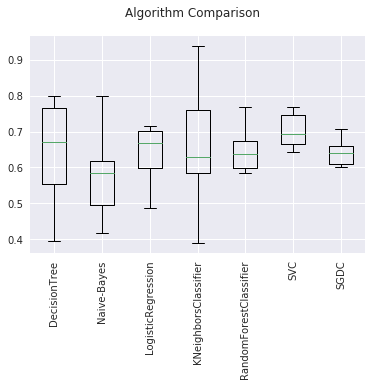

In [8]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

In [9]:
#seleciona os melhores atributos por modelo
for model in res_models:

    if model['name'] in ['Naive-Bayes', 'KNeighborsClassifier', 'SVC']:
        model['best_columns'] = []
        continue
    
    print(model['name'])
    print('-'*len(model['name']))
        
    #seleciona os melhores atributos para cada modelo
    selector = RFECV(model["best_model"], cv=10, n_jobs=-1)
    selector.fit(Xtest, ytest)

    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n{}\n".format(best_columns))    
    
    #salva os melhores atributos para o modelo
    model['best_columns'] = best_columns   
    
#print(res_models[0]['best_columns'])    
    

DecisionTree
------------
Best Columns 
['idade', 'qnt_pc', 'qnt_salarios', 'descricao_imovel_Próprio', 'pessoa_fisica__sexo_M', 'sigla_CA', 'sigla_SC']

LogisticRegression
------------------
Best Columns 
['idade', 'possui_necessidade_especial', 'descricao_area_residencial_Rural', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_historico_Técnico de Nivel Médio em Agropecuária, na Forma Integrada', 'descricao_historico_Técnico de Nível Médio em Administração', 'descricao_historico_Técnico de Nível Médio em Eletrônica', 'descricao_historico_Técnico de Nível Médio em Logística', 'descricao_historico_Técnico de Nível Médio em Mecatrônica', 'descricao_historico_Técnico de Nível Médio em Multimídia', 'descricao_historico_Técnico de Nível Médio em Química', 'descricao_imovel_Cedido ou Emprestado', 'descricao_imovel_Não informado', 'descricao_imovel_Outro', 'descricao_mae_escolaridade_Ensino médio 

DecisionTree
------------
Best Score: 0.6068920810794616
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 5}
Score do conjunto de testes: 0.683788 (0.107212) 

LogisticRegression
------------------
Best Score: 0.6539959580112543
Best Parameters: {'solver': 'newton-cg'}
Score do conjunto de testes: 0.794320 (0.105387) 

RandomForestClassifier
----------------------
Best Score: 0.6469442674031584
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 30}
Score do conjunto de testes: 0.630774 (0.106665) 

SGDC
----
Best Score: 0.6258545646690964
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}
Score do conjunto de testes: 0.711151 (0.082466) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


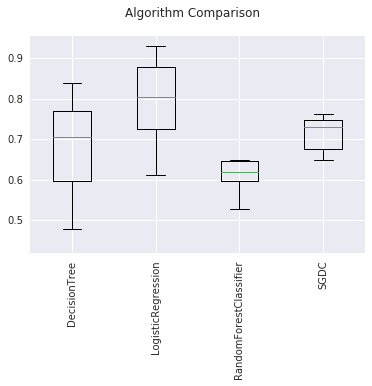

In [10]:
res_models_2 = select_model_tun(Xtrain, Xtest, ytrain, ytest, res_models)           

Score do conjunto de testes: 0.683788 (0.107212) 

Score do conjunto de testes: 0.575854 (0.103247) 

Score do conjunto de testes: 0.794320 (0.105387) 

Score do conjunto de testes: 0.655327 (0.149737) 

Score do conjunto de testes: 0.630774 (0.106665) 

Score do conjunto de testes: 0.679436 (0.097323) 

Score do conjunto de testes: 0.711151 (0.082466) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


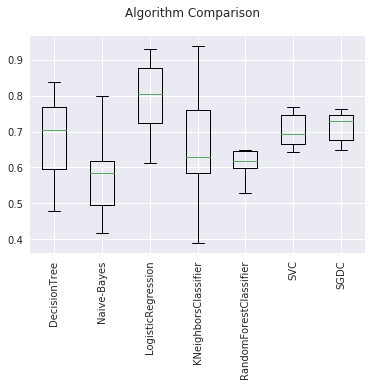

In [11]:
perfomance_compare(res_models_2)



DecisionTree
------------
             precision    recall  f1-score   support

          0       0.63      0.64      0.63        88
          1       0.63      0.62      0.62        87

avg / total       0.63      0.63      0.63       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


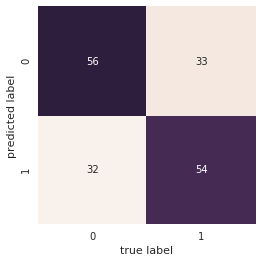

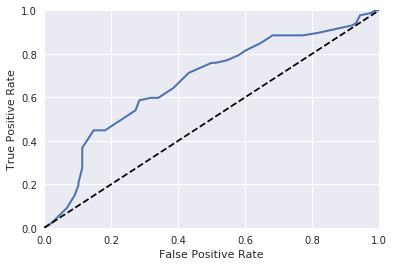

AUC: 0.673002


Naive-Bayes
-----------
             precision    recall  f1-score   support

          0       0.62      0.09      0.16        88
          1       0.51      0.94      0.66        87

avg / total       0.56      0.51      0.41       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


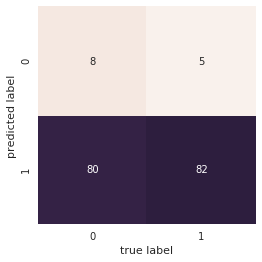

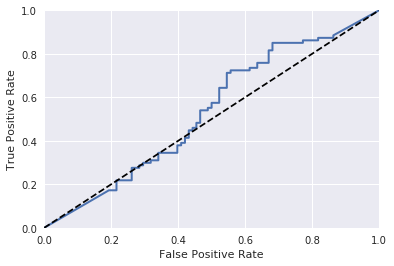

AUC: 0.534809


LogisticRegression
------------------
             precision    recall  f1-score   support

          0       0.73      0.55      0.62        88
          1       0.63      0.79      0.70        87

avg / total       0.68      0.67      0.66       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


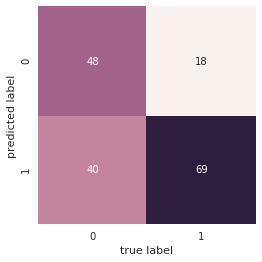

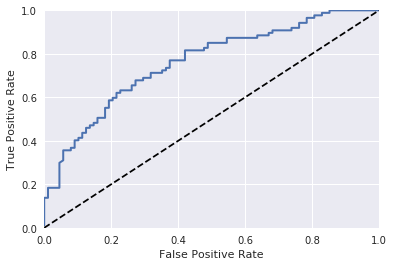

AUC: 0.760253


KNeighborsClassifier
--------------------
             precision    recall  f1-score   support

          0       0.65      0.40      0.49        88
          1       0.56      0.78      0.65        87

avg / total       0.61      0.59      0.57       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


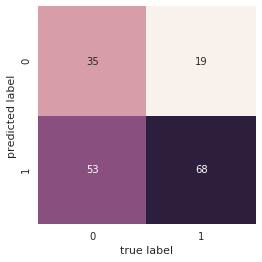

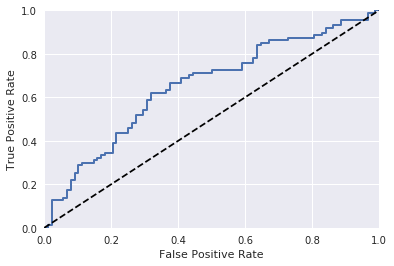

AUC: 0.652429


RandomForestClassifier
----------------------
             precision    recall  f1-score   support

          0       0.61      0.53      0.57        88
          1       0.58      0.66      0.62        87

avg / total       0.60      0.59      0.59       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


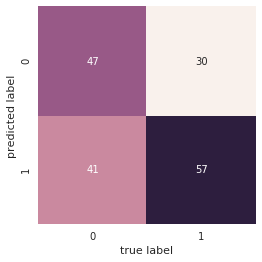

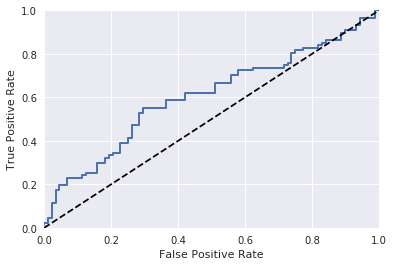

AUC: 0.603840


SGDC
----
             precision    recall  f1-score   support

          0       0.66      0.48      0.55        88
          1       0.59      0.75      0.66        87

avg / total       0.62      0.61      0.60       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


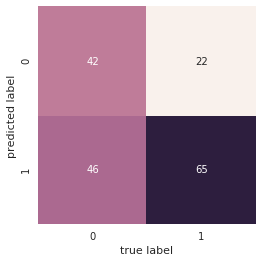

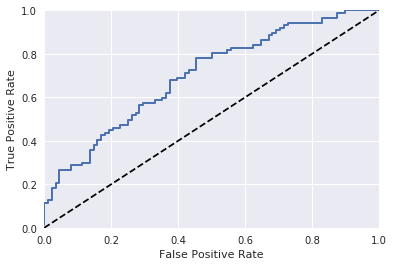

AUC: 0.701149


In [12]:
#avaliacao individual por modelo
for model in res_models:        
    if model['name'] in ['SVC']:
        continue
    
    print('\n\n'+model['name'])
    print('-'*len(model['name']))
    
    Xtest_2  = Xtest
    
    if len(model['best_columns']):
        Xtest_2  = Xtest[model['best_columns']]

    ypred = model['best_model'].predict(Xtest_2)

    evaluating(model['best_model'], ytest, ypred, Xtest_2)

# Cenário 02: utilizando todos os atributos

In [13]:
dados = dados_tunning.copy()

atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

#down sample
dados = down_sample(dados)

print(dados.classe.value_counts())

1    349
0    349
Name: classe, dtype: int64


In [14]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)   

(698, 31)
(698, 31)
(698, 146)


DecisionTree
------------
Best Score: 0.9027961628344037
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 5}
Score do conjunto de testes: 0.883482 (0.089188) 

Naive-Bayes
-----------
Best Score: 0.7276927979604844
Best Parameters: {}
Score do conjunto de testes: 0.665367 (0.088878) 

LogisticRegression
------------------
Best Score: 0.8997101970333328
Best Parameters: {'solver': 'liblinear'}
Score do conjunto de testes: 0.881096 (0.055469) 

KNeighborsClassifier
--------------------
Best Score: 0.8897795427432139
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
Score do conjunto de testes: 0.865551 (0.082695) 

RandomForestClassifier
----------------------
Best Score: 0.9193236478131315
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Score do conjunto de testes: 0.932852 (0.051037) 

SVC
---
Best Score: 0.889602501457186
Best Parameters: {'C': 1, 'gamma': 0.0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


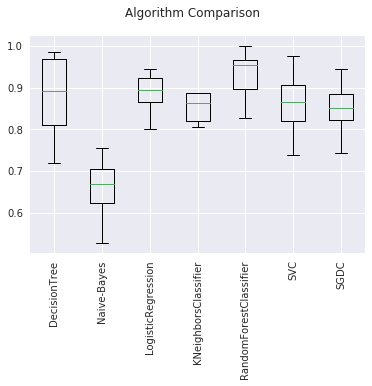

In [15]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

In [16]:
#seleciona os melhores atributos por modelo
for model in res_models:

    if model['name'] in ['Naive-Bayes', 'KNeighborsClassifier', 'SVC']:
        model['best_columns'] = []
        continue
    
    print(model['name'])
    print('-'*len(model['name']))
        
    #seleciona os melhores atributos para cada modelo
    selector = RFECV(model["best_model"], cv=10, n_jobs=-1)
    selector.fit(Xtest, ytest)

    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n{}\n".format(best_columns))    
    
    #salva os melhores atributos para o modelo
    model['best_columns'] = best_columns   

DecisionTree
------------
Best Columns 
['conceito_I', 'conceito_R', 'sigla_MC']

LogisticRegression
------------------
Best Columns 
['conceito_I', 'conceito_O', 'conceito_R', 'conceito_freq_R', 'descricao_area_residencial_Urbana', 'descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros', 'descricao_imovel_Não informado', 'descricao_responsavel_financeiro_Cônjuge', 'sigla_CA']

RandomForestClassifier
----------------------
Best Columns 
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_S', 'conceito_freq_R', 'conceito_freq_S', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_com

DecisionTree
------------
Best Score: 0.9012273046689874
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None}
Score do conjunto de testes: 0.905358 (0.088127) 

LogisticRegression
------------------
Best Score: 0.9017352769742828
Best Parameters: {'solver': 'liblinear'}
Score do conjunto de testes: 0.941355 (0.055669) 

RandomForestClassifier
----------------------
Best Score: 0.9213677937387307
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Score do conjunto de testes: 0.921253 (0.057400) 

SGDC
----
Best Score: 0.8919857495383308
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}
Score do conjunto de testes: 0.863437 (0.076383) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


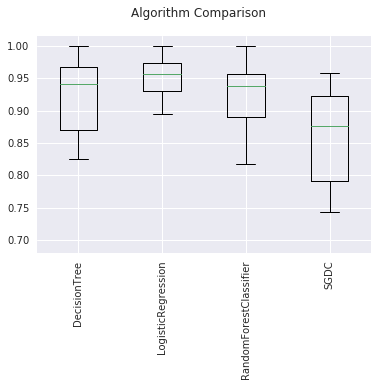

In [17]:
res_models_2 = select_model_tun(Xtrain, Xtest, ytrain, ytest, res_models)           

Score do conjunto de testes: 0.905358 (0.088127) 

Score do conjunto de testes: 0.665367 (0.088878) 

Score do conjunto de testes: 0.941355 (0.055669) 

Score do conjunto de testes: 0.865551 (0.082695) 

Score do conjunto de testes: 0.921253 (0.057400) 

Score do conjunto de testes: 0.865940 (0.068188) 

Score do conjunto de testes: 0.863437 (0.076383) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


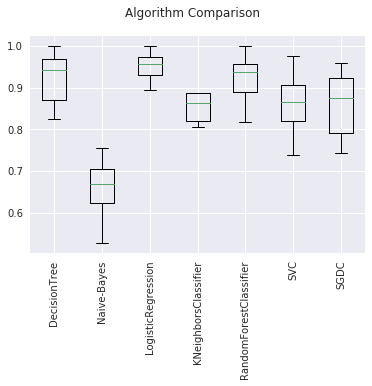

In [18]:
perfomance_compare(res_models_2)



DecisionTree
------------
             precision    recall  f1-score   support

          0       0.86      0.94      0.90        88
          1       0.94      0.84      0.88        87

avg / total       0.90      0.89      0.89       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


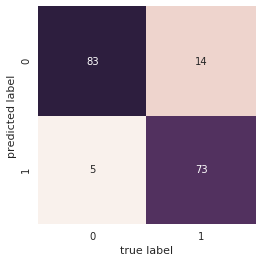

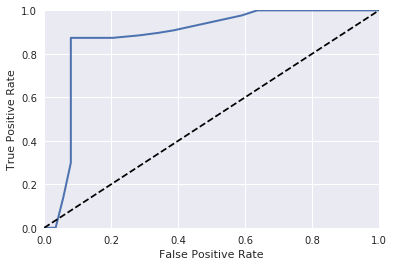

AUC: 0.878657


Naive-Bayes
-----------
             precision    recall  f1-score   support

          0       0.87      0.52      0.65        88
          1       0.66      0.92      0.77        87

avg / total       0.76      0.72      0.71       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


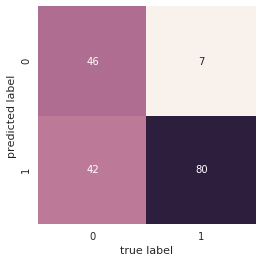

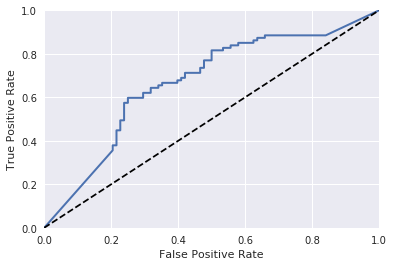

AUC: 0.670324


LogisticRegression
------------------
             precision    recall  f1-score   support

          0       0.86      0.94      0.90        88
          1       0.94      0.84      0.88        87

avg / total       0.90      0.89      0.89       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


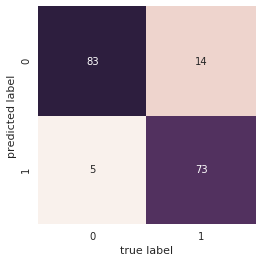

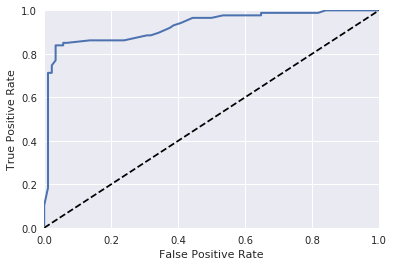

AUC: 0.927965


KNeighborsClassifier
--------------------
             precision    recall  f1-score   support

          0       0.88      0.75      0.81        88
          1       0.78      0.90      0.83        87

avg / total       0.83      0.82      0.82       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


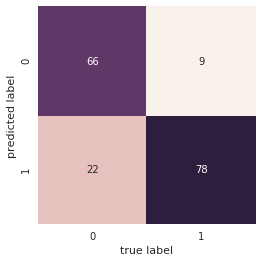

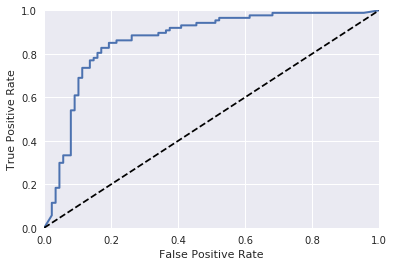

AUC: 0.865073


RandomForestClassifier
----------------------
             precision    recall  f1-score   support

          0       0.85      0.93      0.89        88
          1       0.92      0.84      0.88        87

avg / total       0.89      0.89      0.89       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


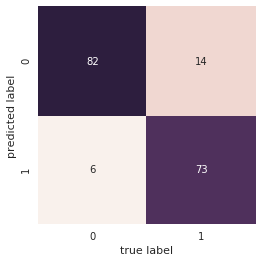

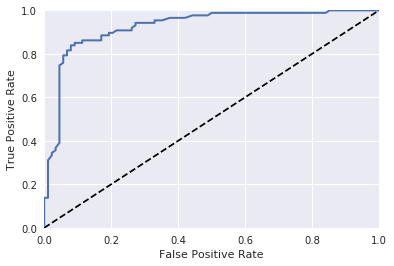

AUC: 0.925157


SGDC
----
             precision    recall  f1-score   support

          0       0.83      0.94      0.88        88
          1       0.93      0.80      0.86        87

avg / total       0.88      0.87      0.87       175



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


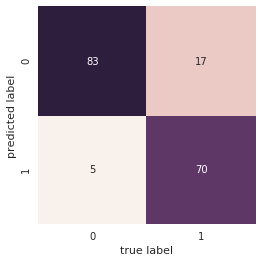

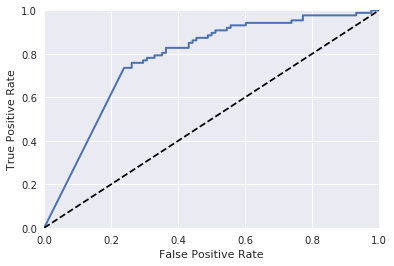

AUC: 0.777821


In [19]:
#avaliacao individual por modelo
for model in res_models:        
    if model['name'] in ['SVC']:
        continue
    
    print('\n\n'+model['name'])
    print('-'*len(model['name']))
    
    Xtest_2  = Xtest
    
    if len(model['best_columns']):
        Xtest_2  = Xtest[model['best_columns']]

    ypred = model['best_model'].predict(Xtest_2)

    evaluating(model['best_model'], ytest, ypred, Xtest_2)

# Cenário 03: usando o modelo do cenário 02 mas sem o downsample

In [6]:
dados = dados_tunning.copy()

atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

1    7369
0     349
Name: classe, dtype: int64


In [7]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)   

(7718, 31)
(7718, 31)
(7718, 151)


DecisionTree
------------
Best Score: 0.9018820905388593
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 5}
Score do conjunto de testes: 0.912779 (0.054636) 

Naive-Bayes
-----------
Best Score: 0.7561315992232595
Best Parameters: {}
Score do conjunto de testes: 0.784697 (0.104449) 

LogisticRegression
------------------
Best Score: 0.9041491920717327
Best Parameters: {'solver': 'liblinear'}
Score do conjunto de testes: 0.937400 (0.024555) 

KNeighborsClassifier
--------------------
Best Score: 0.8494849752519091
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
Score do conjunto de testes: 0.852054 (0.060589) 

RandomForestClassifier
----------------------
Best Score: 0.9276798119186287
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
Score do conjunto de testes: 0.934974 (0.029931) 

SVC
---
Best Score: 0.8683697847002074
Best Parameters: {'C': 10, 'gamma': 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


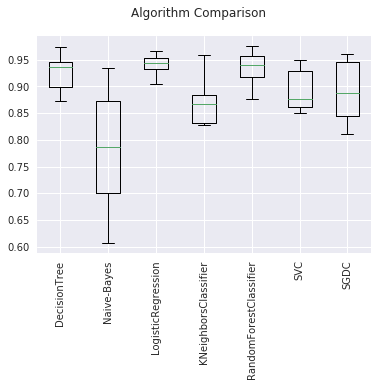

In [8]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

In [9]:
#seleciona os melhores atributos por modelo
for model in res_models:

    if model['name'] in ['Naive-Bayes', 'KNeighborsClassifier', 'SVC']:
        model['best_columns'] = []
        continue
    
    print(model['name'])
    print('-'*len(model['name']))
        
    #seleciona os melhores atributos para cada modelo
    selector = RFECV(model["best_model"], cv=10, n_jobs=-1)
    selector.fit(Xtest, ytest)

    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n{}\n".format(best_columns))    
    
    #salva os melhores atributos para o modelo
    model['best_columns'] = best_columns 

DecisionTree
------------
Best Columns 
['MatemticaI120H_freq', 'conceito_I', 'conceito_R']

LogisticRegression
------------------
Best Columns 
['conceito_I', 'conceito_O', 'conceito_R', 'conceito_freq_R', 'conceito_freq_S', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Pais', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_estado_civil_Solteiro(a)', 'descricao_historico_Técnico de Nivel Médio em Agropecuária, na Forma Integrada', 'descricao_historico_Técnico de Nível Médio em Eletrotécnica', 'descricao_historico_Técnico de Nível Médio em Têxtil', 'descricao_historico_Técnico de Nível Médio em Vestuário', 'descricao_historico_Técnico em Programação de Jogos Digitais', 'descricao_imovel_Financiado', 'descricao_imovel_Não informado', 'descricao_mae_escolaridade_Não estudou', 'descricao_responsavel_escolaridade_Ensino fundamental completo', 'descricao_responsavel_escolaridade_Ensino superior incompleto', 'd

DecisionTree
------------
Best Score: 0.9105858270423932
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 20}
Score do conjunto de testes: 0.888949 (0.054732) 

LogisticRegression
------------------
Best Score: 0.9092396084542683
Best Parameters: {'solver': 'liblinear'}
Score do conjunto de testes: 0.953860 (0.025168) 

RandomForestClassifier
----------------------
Best Score: 0.9263563756777636
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Score do conjunto de testes: 0.936048 (0.043015) 

SGDC
----
Best Score: 0.8969444992938151
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}
Score do conjunto de testes: 0.936486 (0.029119) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


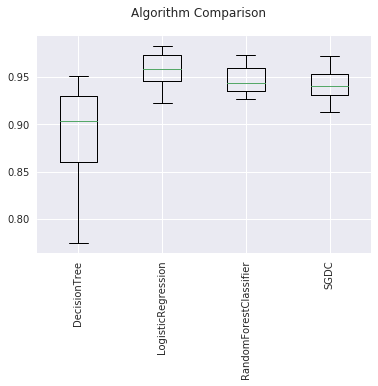

In [10]:
res_models_2 = select_model_tun(Xtrain, Xtest, ytrain, ytest, res_models)     

Score do conjunto de testes: 0.888949 (0.054732) 

Score do conjunto de testes: 0.784697 (0.104449) 

Score do conjunto de testes: 0.953860 (0.025168) 

Score do conjunto de testes: 0.852054 (0.060589) 

Score do conjunto de testes: 0.936048 (0.043015) 

Score do conjunto de testes: 0.874977 (0.067467) 

Score do conjunto de testes: 0.936486 (0.029119) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


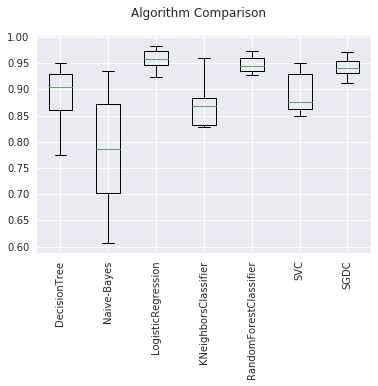

In [11]:
perfomance_compare(res_models_2)



DecisionTree
------------
             precision    recall  f1-score   support

          0       0.74      0.26      0.39        87
          1       0.97      1.00      0.98      1843

avg / total       0.96      0.96      0.95      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


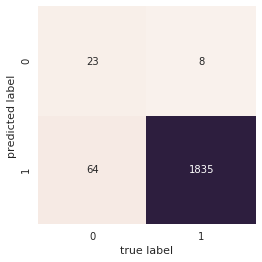

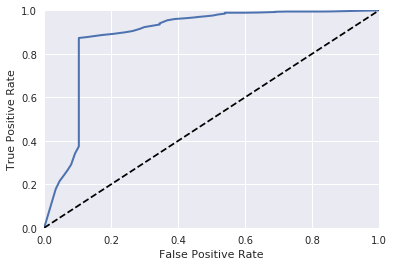

AUC: 0.884789


Naive-Bayes
-----------
             precision    recall  f1-score   support

          0       0.07      0.94      0.13        87
          1       0.99      0.43      0.60      1843

avg / total       0.95      0.45      0.58      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


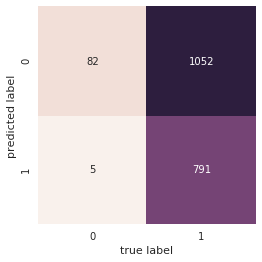

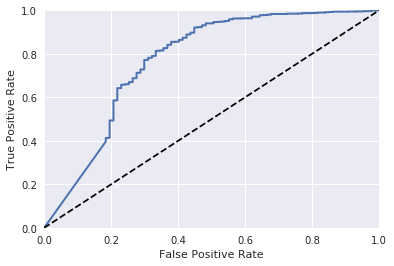

AUC: 0.771724


LogisticRegression
------------------
             precision    recall  f1-score   support

          0       0.75      0.14      0.23        87
          1       0.96      1.00      0.98      1843

avg / total       0.95      0.96      0.95      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


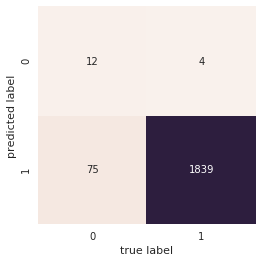

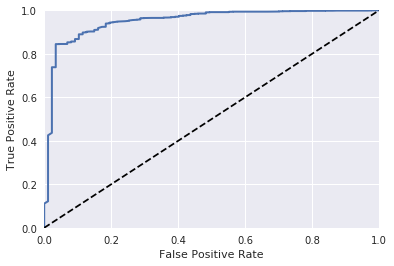

AUC: 0.950019


KNeighborsClassifier
--------------------
             precision    recall  f1-score   support

          0       0.71      0.20      0.31        87
          1       0.96      1.00      0.98      1843

avg / total       0.95      0.96      0.95      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


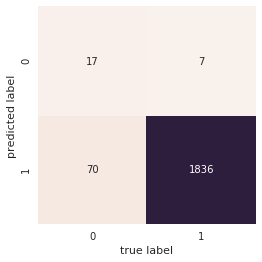

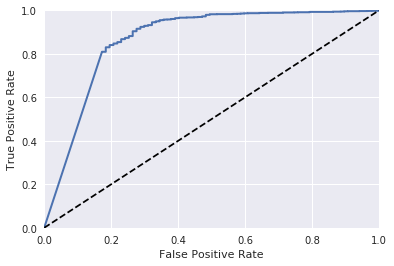

AUC: 0.867732


RandomForestClassifier
----------------------
             precision    recall  f1-score   support

          0       0.87      0.39      0.54        87
          1       0.97      1.00      0.98      1843

avg / total       0.97      0.97      0.96      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


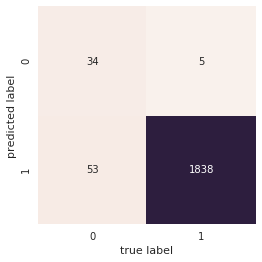

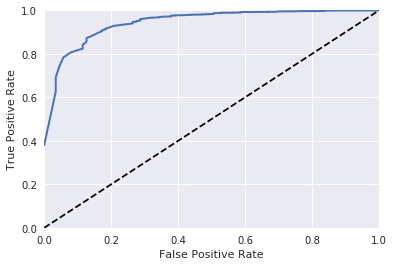

AUC: 0.943355


SGDC
----
             precision    recall  f1-score   support

          0       0.69      0.13      0.21        87
          1       0.96      1.00      0.98      1843

avg / total       0.95      0.96      0.94      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


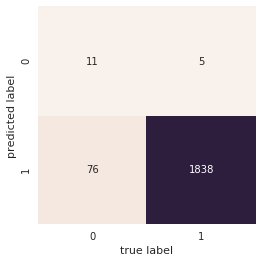

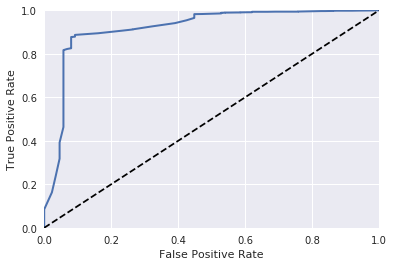

AUC: 0.917273


In [12]:
#avaliacao individual por modelo
for model in res_models:        
    if model['name'] in ['SVC']:
        continue
    
    print('\n\n'+model['name'])
    print('-'*len(model['name']))
    
    Xtest_2  = Xtest
    
    if len(model['best_columns']):
        Xtest_2  = Xtest[model['best_columns']]

    ypred = model['best_model'].predict(Xtest_2)

    evaluating(model['best_model'], ytest, ypred, Xtest_2)

In [ ]:
#FIM